In [1]:
import rospy
import jupyros
from IPython.display import display

from geometry_msgs.msg import Twist, Vector3    #for cmd_vel topic

from jupyros import ros3d
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import ipywidgets as widgets
import actionlib
import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal, MoveBaseActionGoal
import os  
global x
global y
rospy.init_node('jupyter_user_interface')
##pub_goal = rospy.Publisher('/move_base/goal', MoveBaseActionGoal, queue_size = 1000)


In [2]:
def control_velocity(direction):
    
    #initialize a Twist object for the publisher
    init = Vector3(0, 0, 0)
    vel = Twist( init, init)
    
    lin_vel = 0.5
    ang_vel = 0.5
    
    #define velocity to actuate a direction
    if direction == 'u':
        vel.linear.x = lin_vel     
    elif direction == 'r':
        vel.angular.z = -ang_vel   
    elif direction == 'l':
        vel.angular.z = ang_vel
    elif direction == 'd':
        vel.linear.x = -lin_vel
    #initialize the publisher
    pub = rospy.Publisher('remap_cmd_vel',Twist, queue_size=10)
    #pubblic on topic remap_cmd_vel to the robot
    pub.publish(vel)
        

In [3]:
def send_button(b):
    if b == s1:
        with output:
            print(x,y)
            callback_case1(x,y)

In [4]:
def case1():
    x = widgets.BoundedFloatText(
    value = 0.5,
    min = 0.0,
    step = 0.1,
    description = 'x :',
    disabled = False
    )
    y = widgets.BoundedFloatText(
    value = 0.5,
    min = 0.0,
    step = 0.1,
    description = 'y :',
    disabled = False
    )
    display(x,y)



In [5]:
def case2():  
    display(control)
    
    up.on_click(on_button_clicked_direction)
    left.on_click(on_button_clicked_direction)
    right.on_click(on_button_clicked_direction)
    down.on_click(on_button_clicked_direction)

def check_obstacles(b):
    rospy.set_param("/obstacles_avoidance", check.value)

In [6]:
def callback_case1(x,y):
    print("i am in the function")
    client = actionlib.SimpleActionClient('move_base', MoveBaseAction)
    #waiting for the connection with the server
    print("i am waiting")
    client.wait_for_server()
    print("i passed the wait")
    #create the goal
    goal = MoveBaseGoal()
    #set the goal parameter
    goal.target_pose.header.frame_id = 'map'
    goal.target_pose.pose.orientation.w = 1
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    #send the goal
    client.send_goal(goal)
    pub_goal = rospy.Publisher('/move_base/goal', MoveBaseActionGoal, queue_size = 1000)

    finished_within_time = client.wait_for_result(rospy.Duration(60.0))
    if not finished_within_time:
        client.cancel_goal()
        rospy.loginfo("Timed out achieving goal")
        return -1
    else:
        rospy.loginfo("Goal succeeded!")
        return 1


In [7]:
#button activation
def on_button_clicked(b):
    if b == P1:
        with output:
            case1()
            print("case 1")
            display(HBox([s1]), output)
            s1.on_click(send_button)
    if b == P2:
        with output:
            case2()
            
    if b == P3:
        with output:
            case2()
            check.observe(check_obstacles, names='value')
            display(check)

def on_button_clicked_direction(b):
    if b == up:
        control_velocity('u')
    if b == left:
        control_velocity('l')
    if b == right:
        control_velocity('r')
    if b == down:
        control_velocity('d')
        



In [8]:
s1 = Button(description='send X and Y',
    layout=Layout(width='auto', grid_area='s1'),
    style=ButtonStyle(button_color='yellow'))
output = widgets.Output()

up  = Button(description='up',
                 layout=Layout(width='auto', grid_area='up'),
                 style=ButtonStyle(button_color='lightblue'))
left   = Button(description='left',
                 layout=Layout(width='auto', grid_area='left'),
                 style=ButtonStyle(button_color='moccasin'))
right = Button(description='right',
                 layout=Layout(width='auto', grid_area='right'),
                 style=ButtonStyle(button_color='salmon'))
down  = Button(description='down',
                 layout=Layout(width='auto', grid_area='down'),
                 style=ButtonStyle(button_color='olive'))

control=GridBox(children=[up, left, right, down],
        layout=Layout(
            width='50%',
            grid_template_rows='auto auto auto',
            grid_template_columns='25% 25% 25% 25%',
            grid_template_areas='''
            ". up up ."
            "left . .  right "
            ". down down ."
            ''')
       )

check = widgets.Checkbox(
    value = True,
    description='active obstacle avoidance'
)

P1 = Button(description='choosing X and Y',
            layout=Layout(width='auto', grid_area='P1'),
            style=ButtonStyle(button_color='lightblue'))
P2 = Button(description='controlling using keyboard',
            layout=Layout(width='auto', align='center', grid_area='P2'),
            style=ButtonStyle(button_color='green'))
P3 = Button(description='controlling using keyboard and avoiding obstacles',
            layout=Layout(width='auto', grid_area='b3'),
            style=ButtonStyle(button_color='red'))

output = widgets.Output()

display(HBox([P1,P2,P3]), output)


P1.on_click(on_button_clicked)
P2.on_click(on_button_clicked)
P3.on_click(on_button_clicked)


Output()

In [8]:
def display_map():
    #display a live map of the working enviroment of the robot
    
    
    v = ros3d.Viewer()
    rc = ros3d.ROSConnection(url="ws://localhost:9090")
    tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')

    laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
    map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client, continuous=True)
    path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc,
    tf_client=tf_client)
    urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client,
    path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
    g = ros3d.GridModel()

    #v.objects = [g, laser_view, map_view, path, urdf]
    v.objects = [laser_view, map_view, urdf]

    display(v)

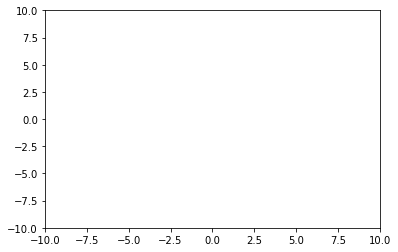

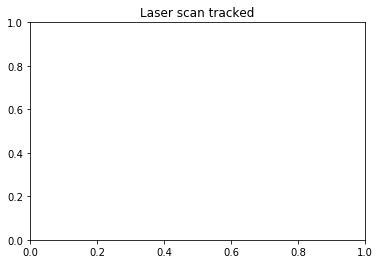

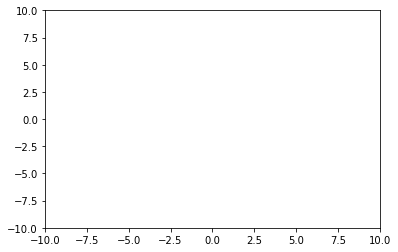

Text(0.5, 1.0, 'position tracked')

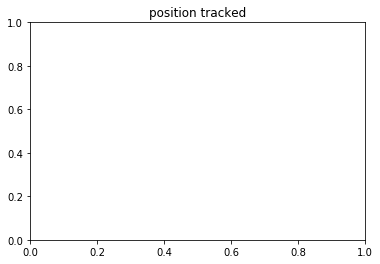

In [10]:
class Visualiser1:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

vis = Visualiser1()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)
plt.title( "position tracked")

In [ ]:
class Visualiser2:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    def laserScan_callback(self, msg):
        self.d_data = msg.ranges
    def update_plot(self, frame):
        self.ln.set_data( self.theta_data, self.d_data )
        return self.ln

vis2 = Visualiser2()    
sub2 = rospy.Subscriber('/scan', LaserScan, vis2.laserScan_callback)
ani2 = FuncAnimation(vis2.fig, vis2.update_plot, init_func=vis2.plot_init)
plt.show(block=True)
plt.title("Laser scan tracked")